In [1]:
from __future__ import division
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import itertools

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [3]:
#load cleaned dataset
dataset = pd.read_csv('cleaned_dataset(1).csv', header=None, skiprows=1);
dataset = dataset.dropna(axis=0);
questions = dataset[0].values
tags = dataset[1].values
#tags = dataset.Tag

#Train-test split
X = questions
y = tags

#strip spaces and all
y = [x.strip() for x in y]


le = preprocessing.LabelEncoder()
le.fit(y)
y = list(le.transform(y))
num_classes = len(set(y))

print "Total classes:", num_classes

#remove single instance classes. As these are useless for now.
single_instance_idx = [i for i in range(len(y)) if y.count(y[i]) <= 1 ]
#print mul_idx

#X = np.delete(X, single_instance_idx);
#y = list(np.delete(y, single_instance_idx));
print "No. of classes with non-single instances in dataset: ", len(set(y))
#convert to BoW rep.

count_vect = CountVectorizer(stop_words='english')
count_vect.fit(X);
X_cnt = count_vect.transform(X)

#tfidf
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_cnt);

#split into train, test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


#print le.inverse_transform(y_test)

#if validation required
#X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


Total classes: 302
No. of classes with non-single instances in dataset:  302


Class Distribution
Shape of X_cnt (1748, 5752)
Unique Classes:  302


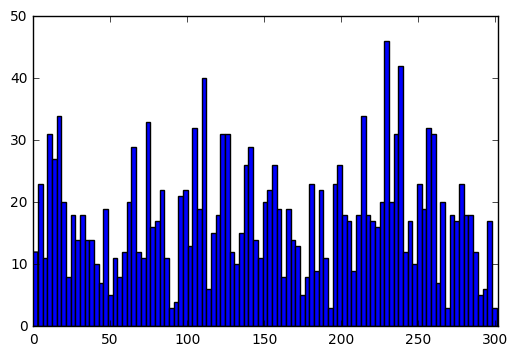

In [4]:
#Visualize
#class distribution
print "Class Distribution"
print "Shape of X_cnt", X_cnt.shape
print "Unique Classes: ", len(set(y))

plt.hist(y, bins=100, histtype='bar', range=(0,304));
plt.xlim(xmin=0, xmax = 302)
plt.show()

In [5]:
#count-vector representation
X_train_cnt = count_vect.transform(X_train);
X_test_cnt = count_vect.transform(X_test);

"""
#
only count => 0.17 (NB), 0.19 (linear svm no tuning)
tfidf => 0.14 (NB), 0.3179 (linear svm n.t.)
"""

#tf-idf based representation
X_train_tfidf = tfidf_transformer.transform(X_train_cnt);
X_test_tfidf = tfidf_transformer.transform(X_test_cnt);

/usr/local/lib/python2.7/dist-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [6]:
#classifier

#train

#Multinomial NB
clf = MultinomialNB();
clf.fit(X_train_tfidf, y_train)

print "Naive Bayes : Train Acc.", np.mean(y_train == clf.predict(X_train_tfidf))
print "Naive Bayes : Test Acc.", np.mean(y_test == clf.predict(X_test_tfidf))

#SVM
clfSVM = SGDClassifier(class_weight="balanced")
clfSVM.fit(X_train_tfidf, y_train)
pred = clfSVM.predict(X_test_tfidf)

print  "Lin-SVM Train Acc.", np.mean(y_train == clfSVM.predict(X_train_tfidf))
print  "Lin-SVM Test Acc.", np.mean(y_test == clfSVM.predict(X_test_tfidf))

#Random Forest
clfRF = RandomForestClassifier(n_estimators=40, max_depth=10, random_state=42)
clfRF.fit(X_train_tfidf, y_train)

print  "RF Train Acc.", np.mean(y_train == clfRF.predict(X_train_tfidf))
print  "RF Test Acc.", np.mean(y_test == clfRF.predict(X_test_tfidf))

Naive Bayes : Train Acc. 0.6258941344778255
Naive Bayes : Test Acc. 0.2742857142857143
Lin-SVM Train Acc. 0.9792560801144492
Lin-SVM Test Acc. 0.42857142857142855
RF Train Acc. 0.5915593705293276
RF Test Acc. 0.26857142857142857


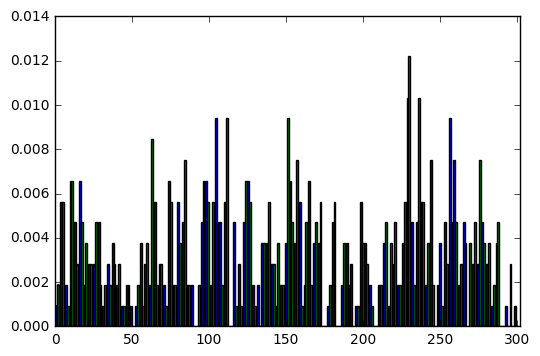

In [7]:
#Visualization of results
plt.hist([y_test, pred], color = ['blue', 'green'], bins=100, normed=1, histtype='bar', range=(0,304));
plt.xlim(xmin=0, xmax = 302)
plt.show()

In [8]:
#confusion matrix
y_pred = clfSVM.predict(X_test_tfidf)
cnf_matrix = confusion_matrix(y_test, y_pred)
np.savetxt('cnf_mat_svm.csv',cnf_matrix, fmt='%1.4f')

class_acc = {}
class_labels = le.inverse_transform(y_test)

for i in range(len(y_test)):
    class_idx = y_test[i]
    tag_ = class_labels[i]

    if (class_acc.has_key(tag_) is False):
        class_acc[tag_] = 0;
        
    class_acc[tag_] += (y_test[i] == y_pred[i])

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
